In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

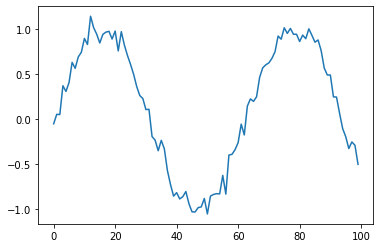

In [3]:
x = np.arange(0,10, 0.1)
y = np.sin(x) + np.random.normal(scale=0.08, size=len(x))
plt.plot(y)

In [4]:
scaler = MinMaxScaler()
norm_y = scaler.fit_transform(y.reshape(-1, 1))

In [5]:
def get_windows(ts, beg, end, wsize, target_period):
    windows = []
    targets = []
    
    beg = beg + wsize
    for i in range(beg, end):
        indicies = range(i-wsize, i)
        windows.append(np.reshape(ts[indicies], (wsize, 1)))
        targets.append(ts[i + target_period])
    return np.array(windows), np.array(targets)

In [6]:
TRAINSPLIT = int(0.6*len(y))
window_size = 10
target_period = 0

train_windows, train_targets = get_windows(norm_y, 0, TRAINSPLIT, window_size, target_period)
test_windows, test_targets = get_windows(norm_y, TRAINSPLIT, len(y), window_size, target_period)
test_windows_unscale, test_targets_unscale = get_windows(y, TRAINSPLIT, len(y), window_size, target_period)
all_windows, all_targets = get_windows(norm_y, 0, len(y), window_size, target_period)

In [7]:
def plotwindow(data, pred, ax=None):
    plt.plot(data[1], label="Target", marker='o',linestyle='None')
    if pred:
        plt.plot(pred, label="Prediction", marker='x', linestyle='None')
    t = list(range(-data[0].shape[0], 0))
    plt.plot(t, data[0].flatten(), label="History", marker='.')
    plt.xlim(t[0], 5)
    plt.legend()
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

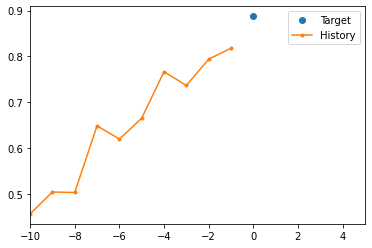

In [8]:
plotwindow([train_windows[0], train_targets[0]], None)

In [61]:
train_windows_tensor = torch.Tensor(train_windows)
train_targets_tensor = torch.Tensor(train_targets)
train_data = torch.utils.data.TensorDataset(train_windows_tensor, train_targets_tensor)
dataloader = torch.utils.data.DataLoader(train_data, batch_size=5,shuffle=True)

test_windows_tensor = torch.Tensor(test_windows)
test_targets_tensor = torch.Tensor(test_targets)
all_windows_tensor = torch.Tensor(all_windows)
all_targets_tensor = torch.Tensor(all_targets)

In [62]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size = input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features = hidden_size, out_features=num_classes)

        
    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        h_n = h_n.view(-1, self.hidden_size)
        x = self.linear(h_n)
        return x

In [63]:
input_size = 1
hidden_size = 8
num_layers = 1
num_classes = 1

model = Net(input_size, hidden_size, num_classes, num_layers)

In [64]:
print(model)

Net(
  (lstm): LSTM(1, 8, batch_first=True)
  (linear): Linear(in_features=8, out_features=1, bias=True)
)


Finished Training


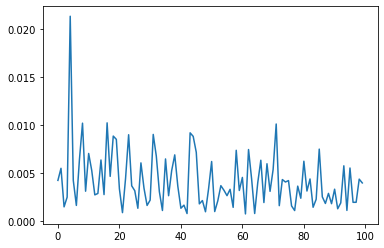

In [66]:
epochs = 10
learning_rate = 0.01

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_values = []
for epoch in range(epochs):
    for data in dataloader:
        w, t = data
        outputs = model(w)
        optimizer.zero_grad()
        loss = criterion(outputs, t)
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())
    
print('Finished Training')
plt.plot(loss_values) #loss function values

In [67]:
all_predict = model(all_windows_tensor)
predict_data = all_predict.data.numpy()
predict_data = scaler.inverse_transform(predict_data)

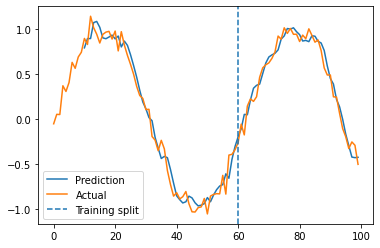

In [68]:
plt.plot(np.arange(window_size, len(y)), predict_data, label="Prediction")
plt.plot(y, label="Actual")
plt.axvline(TRAINSPLIT, linestyle='--', label="Training split")
plt.legend()

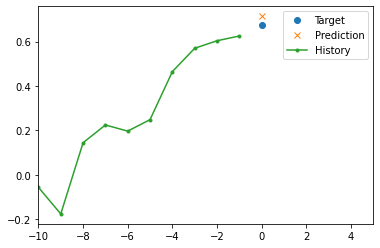

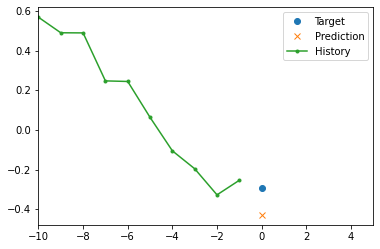

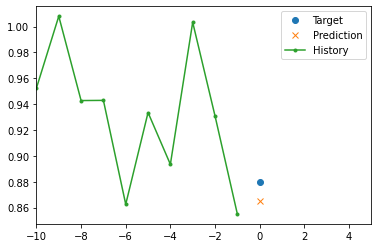

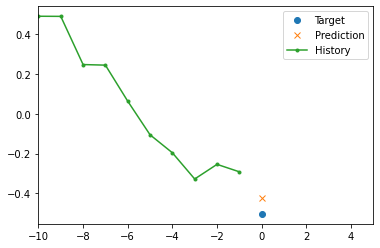

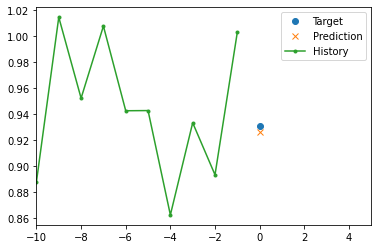

In [69]:
test_indicies = np.random.randint(0, len(y)-TRAINSPLIT-window_size, size=5)
test_predicts = model(test_windows_tensor)
test_predicts = scaler.inverse_transform(test_predicts.data.numpy())
for i in range(5):
    index = test_indicies[i]
    window = test_windows_unscale[index]
    target = test_targets_unscale[index]
    plotwindow([window, target], test_predicts[index])
    plt.show()